In [1]:
from sklearn.metrics import roc_auc_score, roc_curve, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns
from vowpalwabbit import pyvw

##### Создание класса для считывания данных из .txt файла, преобразование их к нужному формату, обучение алгоритма Vowpal Wabbit и дальнейшее предсказание на тестовой выборке:

In [2]:
class ModelVW():
    '''Класс обучения и предсказания алгоритма классификации Vowpal Wabbit'''
    def __init__(self, file, model=pyvw.vw(quiet=True)):
        self.model = model
        self.file = file
        self.l = ['label']
        self.I = ['I{}'.format(i) for i in range(1,14)]
        self.C = ['C{}'.format(i) for i in range(1,27)]
        self.head = [*self.l, *self.I, *self.C]
        
    def fit(self, train_size=0.7):
        '''Метод обучения классификатора, по умолчанию тренировочная выборка составляет 70%'''
        with open(self.file) as self.f:
            self.lines = self.f.readlines()
            self.train_size = round(len(self.lines) * train_size)
            for i in self.lines[:self.train_size]:
                self.string = i.rstrip()
                self.string = self.string.split('\t')
                self.string = self.string + (40 - len(self.string)) * ['']
                self.d = dict(zip(self.head, self.string))
                self.label = str(self.d['label'])
                self.integer = ' '.join([x + ":" + str(self.d[x]) for x in self.I if str(self.d[x]) != ''])
                self.category = ' '.join([x + " " + str(self.d[x]) for x in self.C if str(self.d[x]) != ''])
                self.all = self.label + " |" + self.integer + " | " + self.category
                self.model.learn(self.all)
        return self.model
    
    def predict(self):
        '''Метод предсказания классификатора'''
        self.y_pred = []
        self.y_true = []
        with open(self.file) as self.f:
            self.lines = self.f.readlines()
            for i in self.lines[self.train_size:]:
                self.string = i.rstrip()
                self.string = self.string.split('\t')
                self.string = self.string + (40 - len(self.string)) * ['']
                self.d = dict(zip(self.head, self.string))
                self.label = self.d['label']
                self.y_true.append(self.label)
                self.integer = ' '.join([x + ":" + str(self.d[x]) for x in self.I if str(self.d[x]) != ''])
                self.category = ' '.join([x + " " + str(self.d[x]) for x in self.C if str(self.d[x]) != ''])
                self.all = "|" + self.integer + " | " + self.category
                self.prediction = self.model.predict(self.all)
                self.y_pred.append(self.prediction)
        self.y_true = [int(i) for i in self.y_true]
        return self.y_true, self.y_pred

In [3]:
def roc_auc(y_true, y_pred):
    '''Функция построения roc-auc кривой'''
    sns.set(font_scale=1.5)
    sns.set_color_codes("muted")
    plt.figure(figsize=(10, 8))
    fpr, tpr, thresholds = roc_curve(y_true, y_pred, pos_label=1)
    lw = 2
    plt.plot(fpr, tpr, lw=lw)
    plt.plot([0, 1], [0, 1])
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC curve {}'.format(round(roc_auc_score(y_true, y_pred),2)))
    plt.show()

##### Обучение классификатора и предсказание на тестовой выборке:

In [4]:
%%time
file = "***/train.txt"
# Создадим экземпляр класса
vw = ModelVW(file)

# Обучим модель с размером тренировочной выборки 90%, поскольку данных очень много и на тест останется 4,5млн объектов
vw.fit(0.9)

Wall time: 30min 20s


In [5]:
%%time
# Предскажем результат на тестовой выборке
y_true, y_pred = vw.predict()

Wall time: 4min 40s


##### Оценка качества:

In [6]:
print('ROC AUC: {}'.format(roc_auc_score(y_true, y_pred)))

ROC AUC: 0.7515179091283439


In [7]:
y_pred_ = [1 if i > 0.5 else 0 for i in y_pred]
print('Accuracy: {}'.format(accuracy_score(y_true, y_pred_)))

Accuracy: 0.7674603877521726


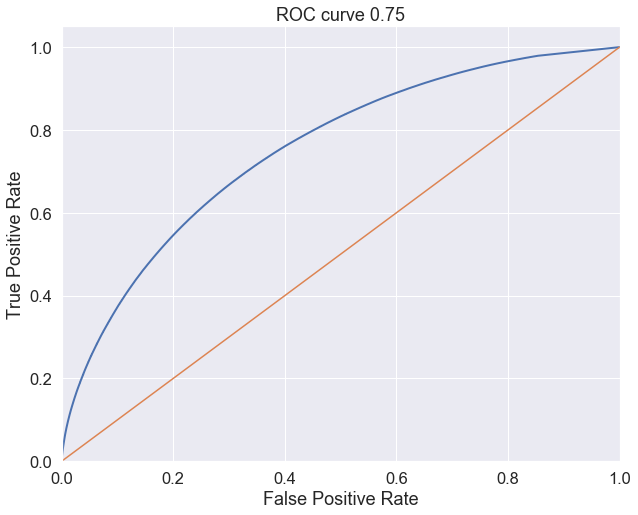

In [8]:
roc_auc(y_true, y_pred)

## Вывод: качество на данном датасете среднее, но в условиях большого объема данных и ограниченного вычислительного ресурса - это оптимальный вариант, поскольку позволяет итерационно по одному объекту обучать модель, тем самым, не выдавая ошибку памяти, и достаточно быстро обучаясь.